#### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier, XGBRegressor


from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from mpl_toolkits.mplot3d import Axes3D

#### Loading Dataset

In [4]:
df_train = pd.read_csv("titanic/train.csv")
df_test = pd.read_csv("titanic/test.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

Let's check how which features are Numerical and which are Categorical

In [5]:
NumericalData = df_train.select_dtypes('number').columns.tolist()
CategoricalData = df_train.select_dtypes(exclude='number').columns.tolist()

print(f"Numerical features: {NumericalData}")
print(f"Categorical features: {CategoricalData}")

Numerical features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


#### Missing Values

In [6]:
train_null = df_train.isna().sum()
test_null = df_test.isna().sum()
missing = pd.DataFrame(
              data=[train_null, train_null/df_train.shape[0]*100,
                    test_null, test_null/df_test.shape[0]*100],
              columns=df_train.columns,
              index=["Train Null", "Train Null (%)", "Test Null", "Test Null (%)"]
          ).T.sort_values(["Train Null", "Test Null"], ascending=False)

In [7]:
# Filter only columns with missing values
missing = missing.loc[(missing["Train Null"] > 0) | (missing["Test Null"] > 0)]
missing

,Train Null,Train Null (%),Test Null,Test Null (%)
Cabin,687.0,77.104377,327.0,78.229665
Age,177.0,19.865320,86.0,20.574163
Embarked,2.0,0.224467,0.0,0.000000
Fare,0.0,0.000000,1.0,0.239234


Now we know what are the missed values, we need to discover the correlations to do what is appropriate

### Numerical data distribution

In [8]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The survival rate for this data - 38.3%
75% of people are below 38 years old
There are outliers in SibSp, Parch, Fare

### The categorical data distribution

In [9]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


There are more instances of Male, than female
There are a duplicates in Ticket and Cabin
74.6 % of passengers used "S" Embarked

### EDA

First, let's how many people survived vs didn't survived

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Died - 549, Survived - 342


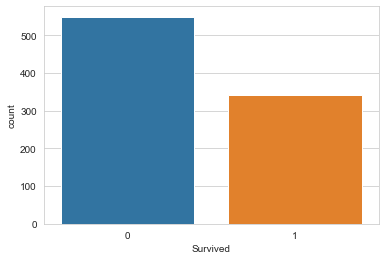

In [10]:
sns.countplot(df_train.Survived)
print(f"Died - {(df_train.Survived == 0).sum()}, Survived - {(df_train.Survived == 1).sum()}")

As we can see,only 38% of the passengers survived

### Feature correlation with Survived

In [11]:
# Help function

def survived_bar_plot(feature):
    plt.figure(figsize = (6,4))
    sns.barplot(data = df_train , x = feature , y = "Survived").set_title(f"{feature} Vs Survived")
    plt.show()
def survived_table(feature):
    return df_train[[feature, "Survived"]].groupby([feature], as_index=True).mean().sort_values(by='Survived', ascending=False).style.background_gradient(low=0.75,high=1)
def survived_hist_plot(feature):
    plt.figure(figsize = (6,4))
    sns.histplot(data = df_train , x = feature , hue = "Survived",binwidth=5,palette = sns.color_palette(["yellow" , "green"]) ,multiple = "stack" ).set_title(f"{feature} Vs Survived")
    plt.show()

#### Sex

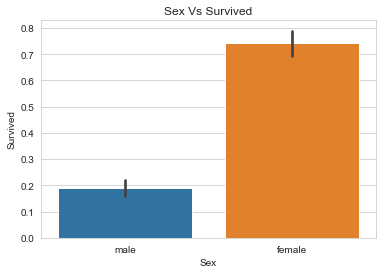

In [12]:
survived_bar_plot("Sex")

In [13]:
survived_table("Sex")

,Survived
Sex,
female,0.742038
male,0.188908


Female have higher Survival rate (74%)

#### pclass

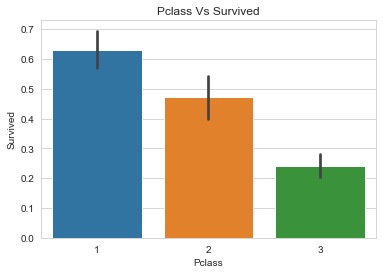

In [14]:
survived_bar_plot("Pclass")

In [15]:
survived_table("Pclass")

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


There is difference in Survival rate between 3 classes

#### Embarked

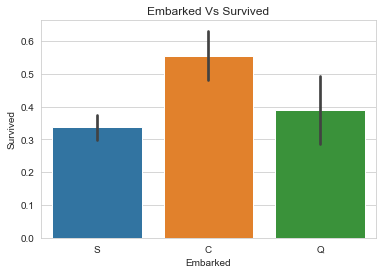

In [16]:
survived_bar_plot("Embarked")

In [17]:
survived_table("Embarked")

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


People who used "C" Embarked have higher Survival rate

#### Parch

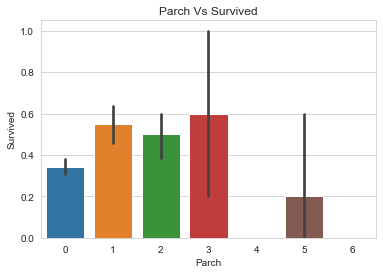

In [18]:
survived_bar_plot("Parch")

In [19]:
survived_table("Parch")

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


Parch feature has zero correlation for some values

#### SibSp

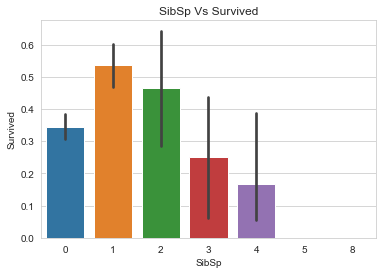

In [20]:
survived_bar_plot("SibSp")

In [21]:
survived_table("SibSp")

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


Likewise in feature "Parch", for some values of SibSp there is no correlation

#### Age

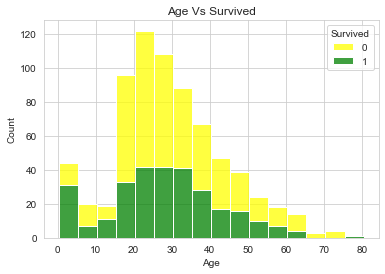

In [22]:
survived_hist_plot("Age")

Age distribution is skewed right. Children are more likely to survive. People after 70 are likely to die.

#### Fare

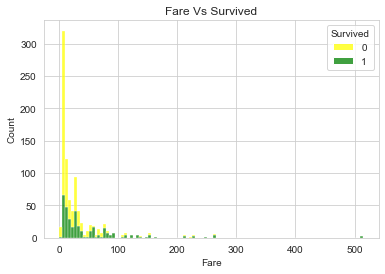

In [23]:
survived_hist_plot("Fare")

There are outliers in this feature

### Correlation between features

<AxesSubplot:>

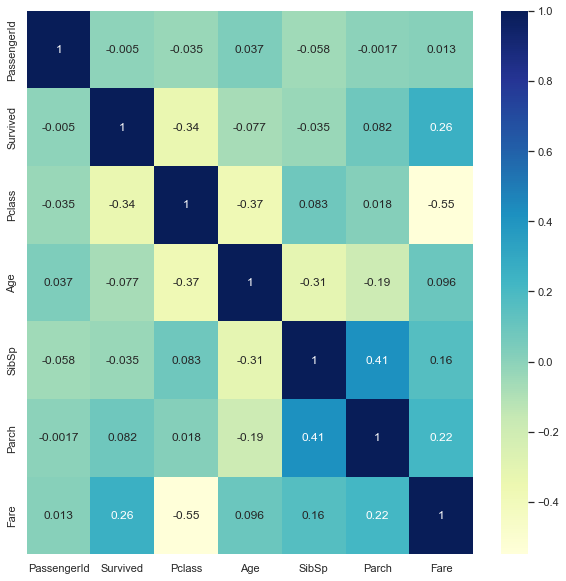

In [24]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_train.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

1) PassengerId has no correlation with other features
2) There is strong negative correlation between Fare and Pclass
3) Age has strong negative correlation with Pclass, SibSp and Parch

### Deleting useless features

In [25]:
df_train.drop(columns=["PassengerId"], inplace=True)

for df in [df_train, df_test]:
    df.drop(columns=["Ticket", "Cabin"], inplace=True)

print("Dropped features")

Dropped features


In [26]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### Dealing with missing values and feature engineering

#### Embarked

In [27]:
df_train = df_train.dropna(subset=["Embarked"])

df_train.Embarked.isna().sum()

0

In [28]:
for df in [df_train, df_test]:
    df.Embarked = df.Embarked.map({
        'S':0,
        'C':1,
        'Q':2
    }).astype(int)

df_train.Embarked.head()

0    0
1    1
2    0
3    0
4    0
Name: Embarked, dtype: int64

#### Sex

In [29]:
for df in [df_train, df_test]:
    df.Sex = df.Sex.map({
        "male": 0,
        "female": 1
    }).astype(int)

df_train.Sex.head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

### Sibsp and Parch

I've decided to combine these features into a new one - family size

In [30]:
for df in [df_train, df_test]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df.drop(columns=["SibSp", "Parch"], inplace=True)

df_train.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,1,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,0,2
4,0,3,"Allen, Mr. William Henry",0,35.0,8.0500,0,1


### Name Title:

In [31]:
for df in [df_train, df_test]:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [32]:
for dataset in [df_train, df_test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset.drop(["Name"], axis=1, inplace=True)

df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.792000
4,Rare,0.347826


In [33]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in [df_train, df_test]:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,7.2500,0,2,1
1,1,1,1,38.0,71.2833,1,2,3
2,1,3,1,26.0,7.9250,0,1,2
3,1,1,1,35.0,53.1000,0,2,3
4,0,3,0,35.0,8.0500,0,1,1


#### Fare

There is 1 missing value in test dataset, so I'll replace it by median (because distribution is skewed right) and delete outliers

In [34]:
df_test.Fare.fillna(df_test.Fare.dropna().median(), inplace=True)

df_test.Fare.isna().sum()

0

In [35]:
df_train.Fare.describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [36]:
p25, p75 = df_train.Fare.describe()[4], df_train.Fare.describe()[6]

IQR = p75 - p25
ul = p75 + 1.5 * IQR
il = p25 - 1.5 * IQR

df_train.Fare.mask(df_train.Fare > ul, ul, inplace=True)
df_train.Fare.mask(df_train.Fare < il, il, inplace=True)

In [37]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,7.2500,0,2,1
1,1,1,1,38.0,65.6563,1,2,3
2,1,3,1,26.0,7.9250,0,1,2
3,1,1,1,35.0,53.1000,0,2,3
4,0,3,0,35.0,8.0500,0,1,1


#### Age

Here I'm planning to use simple model which will predict age missing values

I will use FamilySize and Pclass in order to predict age

In [38]:
age_set = df_train[["Age", "FamilySize", "Pclass"]]
age_set.dropna(inplace=True)

age_set.head()

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/1665104800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_set.dropna(inplace=True)


,Age,FamilySize,Pclass
0,22.0,2,3
1,38.0,2,1
2,26.0,1,3
3,35.0,2,1
4,35.0,1,3


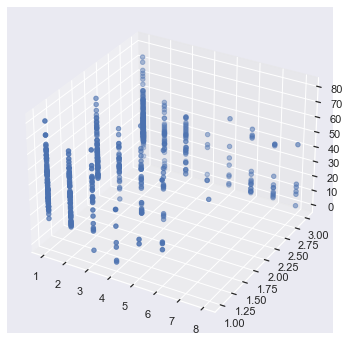

In [39]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train.FamilySize, df_train.Pclass, df_train.Age)

plt.show()

In [40]:
X_train = age_set.drop(["Age"], axis=1)
y_train = age_set.Age

I will use XGboost for the regression

In [41]:
model = XGBRegressor()
CV_results = cross_validate(
    model, X_train, y_train,
    cv=10, scoring=(["neg_root_mean_squared_error"])
)

print(CV_results["test_neg_root_mean_squared_error"].mean())
print("Not bad!")

-13.121464524681775
Not bad!


#### Hyperparameter Tuning

In [42]:
XGBr = XGBRegressor(random_state=0)

params = {
    "max_depth" : (3, 6, 9),
    "learning_rate" : (0.3, 0.1, 0.05),
    "n_estimators" : (50, 75, 100, 150, 200)
}

reg = GridSearchCV(XGBr, params, cv=10)
reg.fit(X_train, y_train)
print("Best hyperparameters:", reg.best_params_)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75}


In [43]:
y_pred = reg.predict(X_train)
print(f"Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}")

Train RMSE: 12.571456141725873


Now we can replace the missing age values with our model!

In [44]:
for df in [df_train, df_test]:
    age_missing = df.loc[df.Age.isna() == True]
    age_missing.Age = reg.predict(age_missing[["FamilySize", "Pclass"]])
    df.Age.loc[df.Age.isna() == True] = round(age_missing.Age)


/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/2566537409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_missing.Age = reg.predict(age_missing[["FamilySize", "Pclass"]])
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/2566537409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Age.loc[df.Age.isna() == True] = round(age_missing.Age)
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/2566537409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Now there are no missing values

In [45]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
FamilySize    0
Title         0
dtype: int64

In [46]:
df_test.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
FamilySize     0
Title          0
dtype: int64

### Creating Bands for different features

#### Age Band:

In [47]:
df_train['AgeBand'] = pd.cut(df['Age'], 5)
df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.0942, 15.336]",0.243243
1,"(15.336, 30.502]",0.434043
2,"(30.502, 45.668]",0.333333
3,"(45.668, 60.834]",0.357143
4,"(60.834, 76.0]",0.500000


In [48]:
for dataset in [df_train, df_test]:
    dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 30), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 45), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 60), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 4

df_train.Age.head()

0    1.0
1    2.0
2    1.0
3    2.0
4    2.0
Name: Age, dtype: float64

In [49]:
df_train.drop(['AgeBand'], axis=1, inplace=True)

#### Fare Band

In [50]:
df_train['FareBand'] = pd.qcut(df_train['Fare'], 4)
df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=False)

,FareBand,Survived
3,"(31.0, 65.656]",0.577273
2,"(14.454, 31.0]",0.454955
1,"(7.896, 14.454]",0.303571
0,"(-0.001, 7.896]",0.197309


In [51]:
for dataset in [df_train, df_test]:
    dataset.loc[ dataset['Fare'] <= 8, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 8) & (dataset['Fare'] <= 15), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 15) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

df_train.drop(['FareBand'], axis=1 , inplace = True)

In [52]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,1.0,0,0,2,1
1,1,1,1,2.0,3,1,2,3
2,1,3,1,1.0,0,0,1,2
3,1,1,1,2.0,3,0,2,3
4,0,3,0,2.0,1,0,1,1


#### Family Size

In [53]:
for dataset in [df_train, df_test]:
    dataset['Single'] = dataset['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    dataset['SmallF'] = dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    dataset['MedF'] = dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    dataset['LargeF'] = dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df_train.drop(columns = ["FamilySize"] , inplace = True)
df_test.drop(columns = ["FamilySize"] , inplace = True)

In [54]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Single,SmallF,MedF,LargeF
0,0,3,0,1.0,0,0,1,0,1,0,0
1,1,1,1,2.0,3,1,3,0,1,0,0
2,1,3,1,1.0,0,0,2,1,0,0,0
3,1,1,1,2.0,3,0,3,0,1,0,0
4,0,3,0,2.0,1,0,1,1,0,0,0


### Building a model

### Splitting Dataset

In [55]:
X_train = df_train.drop(["Survived"], axis=1)
y_train = df_train.Survived

X_test = df_test.drop("PassengerId", axis=1)

X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Single,SmallF,MedF,LargeF
0,3,0,1.0,0,0,1,0,1,0,0
1,1,1,2.0,3,1,3,0,1,0,0
2,3,1,1.0,0,0,2,1,0,0,0
3,1,1,2.0,3,0,3,0,1,0,0
4,3,0,2.0,1,0,1,1,0,0,0


### Selecting Best Model

In [56]:
classifiers = {
    "Logistic Regression" : LogisticRegression(),
    "Naive Bayes" : MultinomialNB(),
    "SVM" : SVM(),
    "KNN" : KNeighborsClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "GB Classifier" : GradientBoostingClassifier(),
    "XGB Classifier" : XGBClassifier()
}

results = pd.DataFrame(columns=["Classifier", "AVG_Accuracy"])
for name, clf in classifiers.items():
    model = clf
    CV_results = cross_validate(
        model, X_train, y_train,
        cv=10, scoring=(["accuracy"])
    )

    results = results.append({
        "Classifier" : name,
        "AVG_Accuracy": CV_results['test_accuracy'].mean()
    }, ignore_index=True)

results = results.sort_values("AVG_Accuracy", ascending=False)
results.reset_index(drop=True)

/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/382683841.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/382683841.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/382683841.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_59639/382683841.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/19/6fxk39qn

,Classifier,AVG_Accuracy
0,GB Classifier,0.830158
1,SVM,0.827911
2,KNN,0.82117
3,XGB Classifier,0.821157
4,Logistic Regression,0.81776
5,Random Forest,0.814402
6,Naive Bayes,0.79308


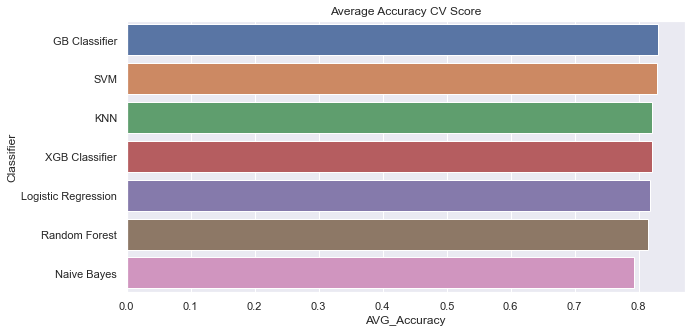

In [57]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x="AVG_Accuracy", y="Classifier")
plt.title("Average Accuracy CV Score")
plt.show()

The best classifiers are: GB, SVM, KNN, XGB. Let's tune their hyperparameters

### Hyperparameters Tuning

### GB

In [86]:
GB = GradientBoostingClassifier(random_state = 0)

params = {
    "max_depth" : (3, 6, 9),
    "learning_rate" : (0.1, 0.01, 0.001),
    "n_estimators" : (50, 75, 100, 200, 250),

}

gb = GridSearchCV(GB, params, cv=10)
gb.fit(X_train, y_train)

print("Best hyperparameters for GB:", gb.best_params_)

Best hyperparameters for GB: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


In [87]:
gb.best_score_

0.8368871297242084

#### SVM

In [ ]:
SVM = SVM(random_state=0)

In [82]:

params = {
    "kernel": ["poly", "rbf"],
    "C" : [0.1, 1, 3, 7],
    "gamma": [0.1, "scale", "auto"],
    "probability": [True]
}

svm = GridSearchCV(SVM, params, cv=10)
svm.fit(X_train, y_train)
print("Best hyperparameters:", svm.best_params_)

Best hyperparameters: {'C': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}


In [84]:
svm.best_score_

0.8312691521961184

#### KNN

In [71]:
KNN = KNeighborsClassifier()

params = {
    "n_neighbors": [3, 7, 10, 15],
    "leaf_size": [10, 20, 30, 40],
    "weights": ['uniform', 'distance']
}

knn = GridSearchCV(KNN, params, cv=10)
knn.fit(X_train, y_train)
print("Best hyperparameters:", knn.best_params_)

Best hyperparameters: {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}


In [88]:
knn.best_score_

0.8402579162410623

### XGB

In [74]:
XGB = XGBClassifier(random_state = 0)

params = {
    "max_depth" : (3, 4, 5, 6, 8, 9),
    "learning_rate" : (10, 1, 0.1),
    "n_estimators" : (50, 75, 100, 200),
}

xgb = GridSearchCV(XGB, params, cv=10)
xgb.fit(X_train, y_train)
print("Best hyperparameters:", xgb.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [89]:
xgb.best_score_

0.8391726251276813

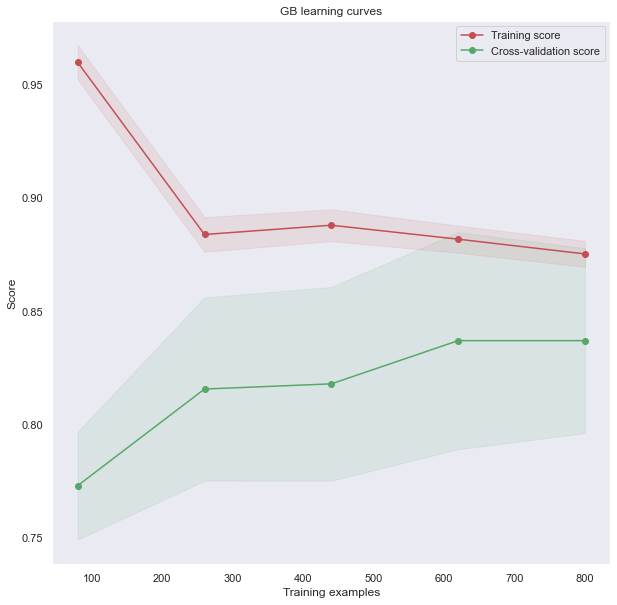

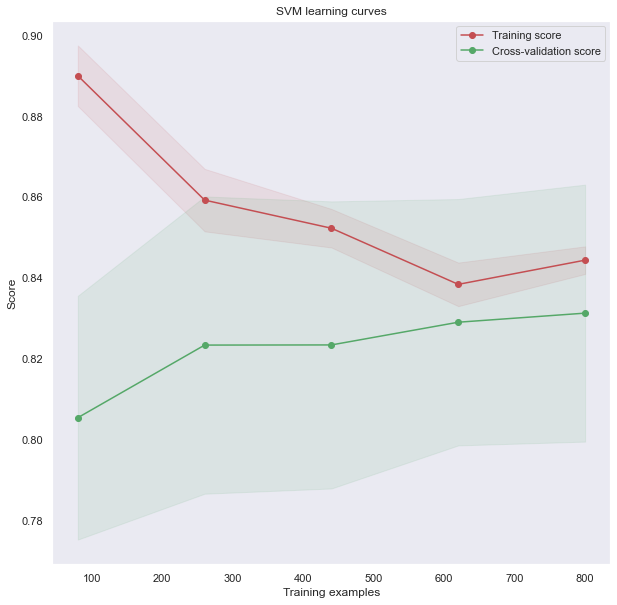

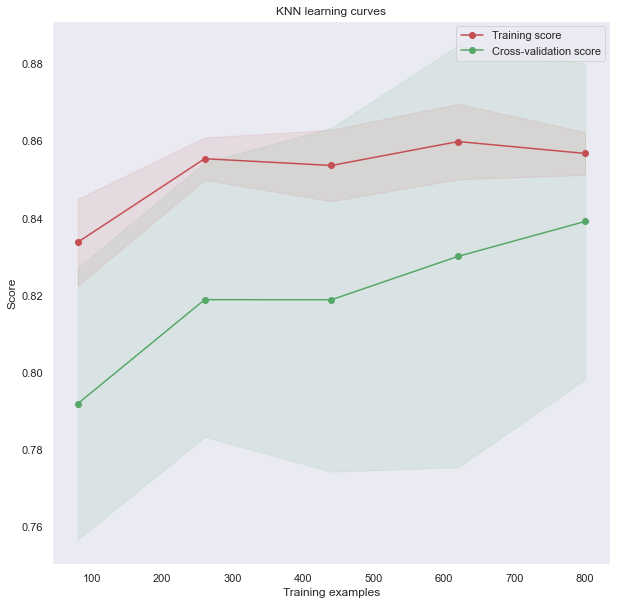

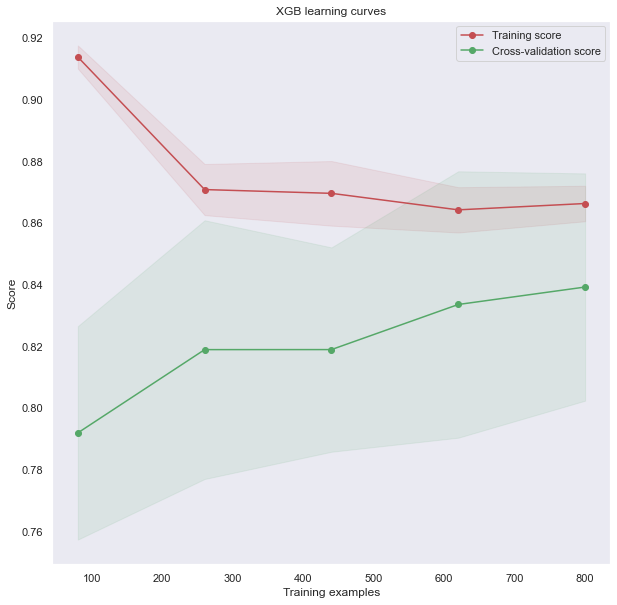

In [90]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gb.best_estimator_,"GB learning curves",X_train,y_train,cv=10)
g = plot_learning_curve(svm.best_estimator_,"SVM learning curves",X_train,y_train,cv=10)
g = plot_learning_curve(knn.best_estimator_,"KNN learning curves",X_train,y_train,cv=10)
g = plot_learning_curve(xgb.best_estimator_,"XGB learning curves",X_train,y_train,cv=10)

<AxesSubplot:>

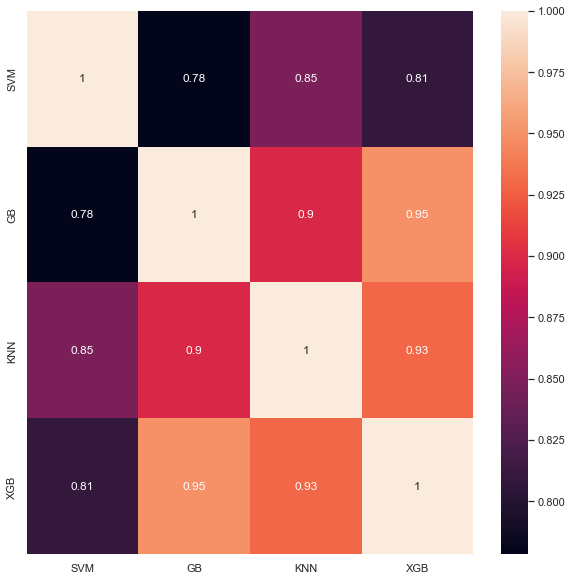

In [91]:
test_Survived_SVM = pd.Series(svm.predict(X_test), name="SVM")
test_Survived_GB = pd.Series(gb.predict(X_test), name="GB")
test_Survived_KNN = pd.Series(knn.predict(X_test), name="KNN")
test_Survived_XGB = pd.Series(xgb.predict(X_test), name="XGB")

# Concatenate all classifier results
combined_results = pd.concat([test_Survived_SVM, test_Survived_GB, test_Survived_KNN, test_Survived_XGB], axis=1)

sns.heatmap(combined_results.corr(), annot=True)

### Combining models into one

In [92]:
votingClf = VotingClassifier(estimators=[
    ('SVM', svm),
    ('GB', gb),
    ('KNN', knn),
    ("XGB", xgb)
], voting='soft', n_jobs=4)

votingClf = votingClf.fit(X_train, y_train)

### Make submission

In [93]:
y_pred = votingClf.predict(X_test)

submission = pd.DataFrame({
    "PassengerId" : df_test.PassengerId,
    "Survived" : y_pred
})

submission.to_csv("submission.csv", index=False)